## Vehicle Detection and Tracking
***
This notebook is mainly about how we detect the vehicles in the image and how we track the detected vehicles in the video. The reference code and knowledge is in Udacity related lectures.

### Import Library

In [1]:
# Import necessary lib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

/Users/Gin/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load and Visualize the Data
***
Here, the data of cars and noncars from Udacity is loaded and visualized.

Number of car images = 8792
Number of noncar images = 8968
Image shape = (64, 64, 3)


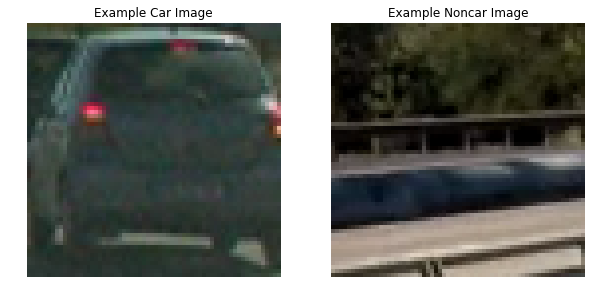

In [2]:
# Load data from the file 
cars = glob.glob('vehicles/*/*.png')
noncars = glob.glob('non-vehicles/*/*.png')
print('Number of car images =', len(cars))
print('Number of noncar images =', len(noncars))

# Plot the one of the car and one of the noncar images
ind = np.random.randint(0, len(cars))
car_sample = mpimg.imread(cars[ind])
ind_n = np.random.randint(0, len(noncars))
noncar_sample = mpimg.imread(noncars[ind_n])
print('Image shape =', car_sample.shape)
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 10))
ax1.imshow(car_sample)
ax1.axis('off')
ax1.set_title('Example Car Image')
ax2.imshow(noncar_sample)
ax2.axis('off')
ax2.set_title('Example Noncar Image')

## Features Extraction
***
Here functions 

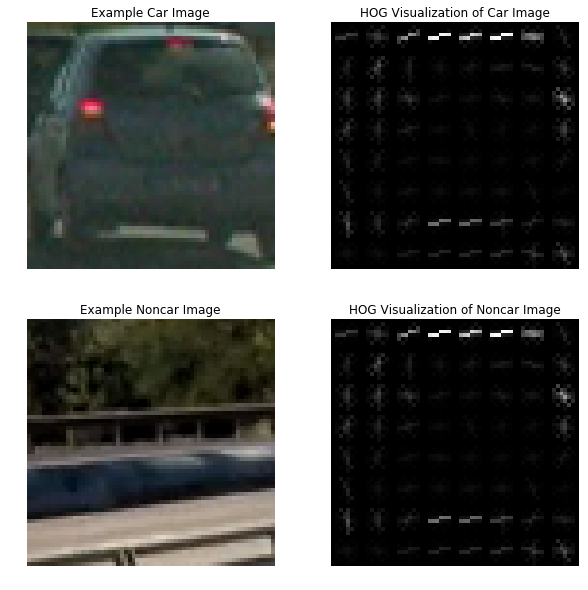

In [3]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                    vis = False, feature_vec = True):
        if vis:
            # Use skimage.hog() to get features and visualize
            features, hog_image = hog(img, orientations = orient, pixels_per_cell = (pix_per_cell, pix_per_cell),
                                     cells_per_block = (cell_per_block, cell_per_block), transform_sqrt = False, visualise = True, feature_vector = False)
            return features, hog_image
        else:
            # Get features only
            features = hog(img, orientations = orient, pixels_per_cell = (pix_per_cell, pix_per_cell),
                          cells_per_block = (cell_per_block, cell_per_block), transform_sqrt = False, visualise = False, feature_vector = False)
            return features

# Convert image from rgb to gray
gray_car_sample = cv2.cvtColor(car_sample, cv2.COLOR_RGB2GRAY)
gray_noncar_sample = cv2.cvtColor(noncar_sample, cv2.COLOR_RGB2GRAY)

# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Call functions
_, hog_car = get_hog_features(gray_car_sample, orient, pix_per_cell, cell_per_block,
                    vis = True, feature_vec = True)
_, hog_noncar = get_hog_features(gray_noncar_sample, orient, pix_per_cell, cell_per_block,
                    vis = True, feature_vec = True) 

# Plot Samples
fig = plt.figure(figsize = (10, 10))
plt.subplot(221)
plt.imshow(car_sample)
plt.title('Example Car Image')
plt.axis('off')
plt.subplot(222)
plt.imshow(hog_car, cmap = 'gray')
plt.axis('off')
plt.title('HOG Visualization of Car Image')
plt.subplot(223)
plt.imshow(noncar_sample)
plt.title('Example Noncar Image')
plt.axis('off')
plt.subplot(224)
plt.imshow(hog_car, cmap = 'gray')
plt.axis('off')
plt.title('HOG Visualization of Noncar Image')


In [4]:
# def bin_spatial(img, color_space = 'RGB', size = (32, 32)):
def bin_spatial(img, size = (32, 32)):
    # Convert image to required color space 
#     if color_space != 'RGB':
#         if color_space == 'HSV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#         elif color_space == 'LUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
#         elif color_space == 'HLS':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#         elif color_space == 'YUV':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
#         elif color_space == 'YCrCb':
#             feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
#     else: 
#         feature_image = np.copy(img) 
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins = 32, bins_range = (0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:, :, 0], nbins, bins_range)
    ghist = np.histogram(img[:, :, 1], nbins, bins_range)
    bhist = np.histogram(img[:, :, 2], nbins, bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [5]:
def extract_features(images, color_space = 'RGB', spatial_size = (32, 32),
                    hist_bins = 32, orient = 9, pix_per_cell = 8, cell_per_block = 2,
                    hog_channel = 0, spatial_feat = True, hist_feat = True, hog_feat = True):
    features = []
    for filename in images:
        img_features = []
        img = mpimg.imread(filename)
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(img)
        
        if spatial_feat:
            spatial_features = bin_spatial(feature_image, size = spatial_size)
            img_features.append(spatial_features)
        
        if hist_feat:
            hist_features = color_hist(feature_image, hist_bins)
            img_features.append(hist_features)
        
        if hog_feat:
            hog_features = []
            for i in range(hog_channel):
                hog_feature = get_hog_features(feature_image[:,:,i], orient, pix_per_cell, cell_per_block)
                hog_features.append(hog_feature)
            hog_features = np.ravel(hog_features)
        
        img_features.append(hog_features)
        features.append(np.concatenate(img_features))
    return features

In [6]:
# Set parameters
color_space = 'YCrCb'
orient = 10
pix_per_cell = 8
cell_per_block = 2
hog_channel = 3
spatial_size = (32, 32)
hist_bins = 64

car_features = extract_features(cars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel,
                            spatial_feat=True, hist_feat=True,
                            hog_feat=True)
notcar_features = extract_features(noncars, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel,
                            spatial_feat=True, hist_feat=True,
                            hog_feat=True)

In [7]:
X = np.vstack((car_features, notcar_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
X_scaled = X_scaler.transform(X)

y = np.hstack((np.ones(len(cars)), np.zeros(len(noncars))))
assert(X_scaled.shape[0] == y.shape[0])

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

print('Feature vector length =', len(X_train[0]))



Feature vector length = 9144


In [8]:
svc = LinearSVC()
tic = time.time()
svc.fit(X_train, y_train)
tac = time.time()
print('Time to train SVC is %.2fs'%(tac - tic))
print('Test Accuracy of SVC = %.2f%%'%(svc.score(X_test, y_test)*100))
print('Train Accuracy of SVC = %.2f%%'%(svc.score(X_train, y_train)*100))

Time to train SVC is 25.94s
Test Accuracy of SVC = 99.04%
Train Accuracy of SVC = 100.00%


## Sliding Windows and Heat Map Functions

In [9]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 1), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_feature = get_hog_features(feature_image[:,:,channel], 
                        orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True)
                hog_features.append(hog_feature)
            hog_features = np.ravel(hog_features)    
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
    #9) Return concatenated array of features
    return np.concatenate(img_features)

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def show_img(img):
    if len(img.shape)==3: #Color BGR image
        plt.figure()
        plt.imshow(img)
    else: # Grayscale image
        plt.figure()
        plt.imshow(img, cmap='gray')

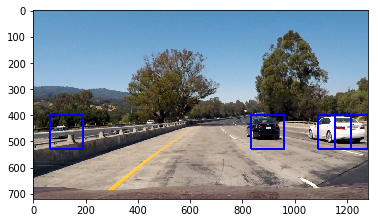

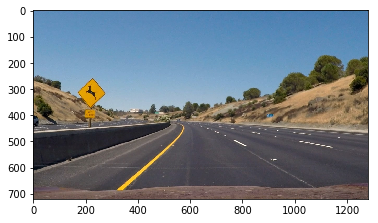

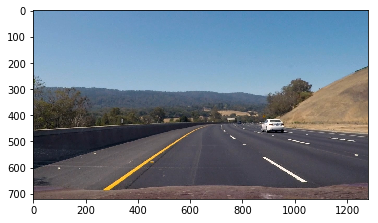

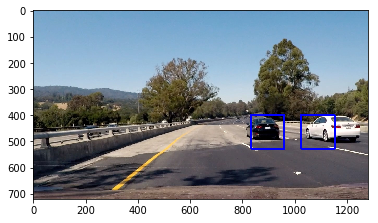

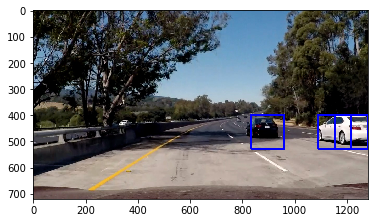

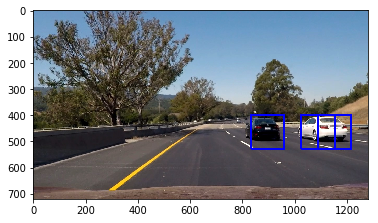

In [10]:
tests = glob.glob('test_images/test*.jpg')
color_space = 'YCrCb'
orient = 10
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL'
spatial_size = (32, 32)
hist_bins = 64
for test in tests:
    img = mpimg.imread(test) 
    img = img.astype(np.float32) / 255
    draw_image = np.copy(img)
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=[400, 640], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
    hot_windows = []
    hot_windows += (search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel))                       
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 1), thick=6)
    show_img(window_img)

    

In [11]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Hog Sub-sampling Window Search
***
A more efficient method for doing the sliding window approach, one that allows us to only have to extract the Hog features once. 

In [12]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    box_lists = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                box_lists.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return box_lists

In [13]:
def show_cars(img, rectangles):
    out_img = draw_boxes(img, rectangles)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, rectangles)
    heat = apply_threshold(heat, 2)
    labels = label(heat)
    output_bbox = draw_labeled_bboxes(np.copy(img), labels)

    fig = plt.figure(figsize = (20, 20))
#     plt.tight_layout()
    plt.subplot(141)
    plt.imshow(out_img)
    plt.title('BBoxes')
    plt.subplot(142)
    plt.imshow(heat, cmap='hot')
    plt.title('Heat Map')
    plt.subplot(143)
    plt.imshow(labels[0], cmap='gray')
    plt.title('Labels Map')
    plt.subplot(144)
    plt.imshow(output_bbox)
    plt.title('Output Boxes')

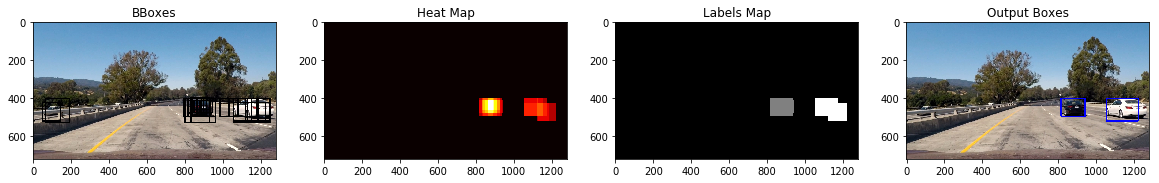

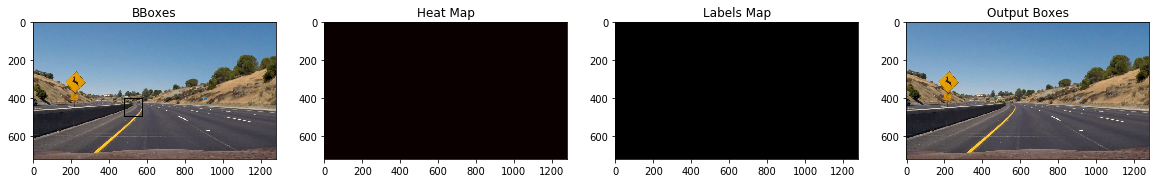

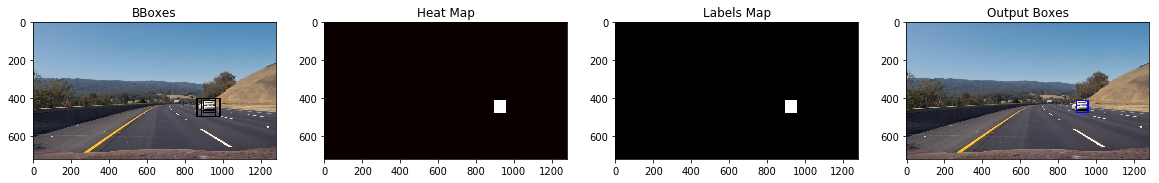

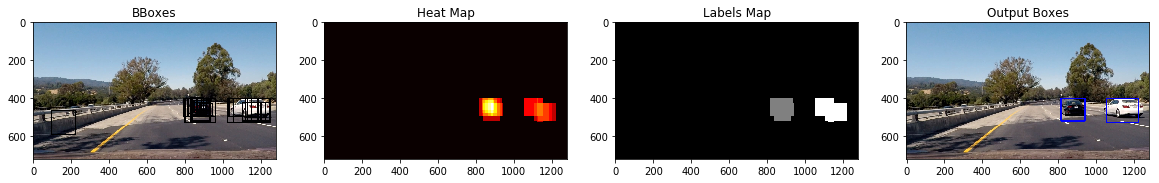

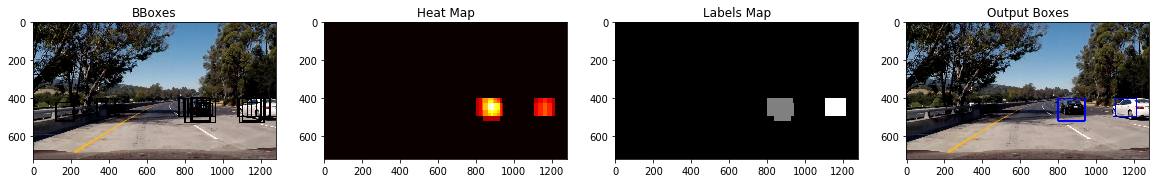

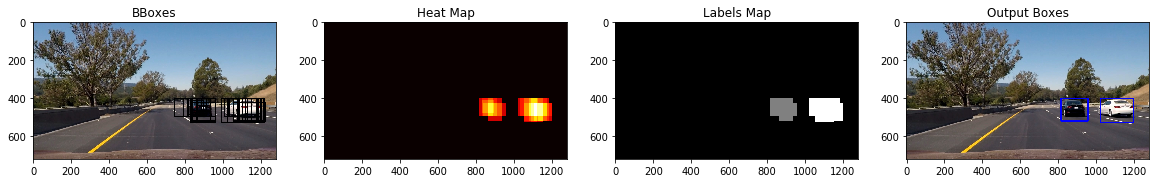

In [14]:
from scipy.ndimage.measurements import label

test_images = glob.glob('./test_images/test*.jpg')
for image in test_images:
    img = mpimg.imread(image)
    ## list parameter
    ## thanks to udacity disscussion form https://discussions.udacity.com/t/hog-sub-sampling-window-search/235413/34
    ## I tried different parameters of suggestions.
    orient=10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    
    rectangles = []
    
    
    ystart = 380
    ystop = 550
    scale = 1.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 600
    scale = 1.5
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 656
    scale = 2.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    out_img = draw_boxes(img, rectangles)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, rectangles)
    heat = apply_threshold(heat, 2)
    labels = label(heat)
    output_bbox = draw_labeled_bboxes(np.copy(img), labels)
    
    show_cars(img, rectangles)
#     f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20,20))
#     plt.tight_layout()
#     ax1.imshow(out_img)
#     ax1.set_title('Bboxes', fontsize=30)
#     ax2.imshow(heat, cmap='hot')
#     ax2.set_title('Heat Map', fontsize=30)
#     ax3.imshow(labels[0], cmap='gray')
#     ax3.set_title('Labels Map', fontsize=30)
#     ax4.imshow(output_bbox)
#     ax4.set_title('Output Boxes', fontsize=30)

## Pipeline in Video
***

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [25]:
def process(img):
    orient=10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    
    rectangles = []
    
    ystart = 350
    ystop = 550
    scale = 1.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    
    ystart = 400
    ystop = 600
    scale = 1.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 600
    scale = 1.5
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 656
    scale = 2.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 596
    scale = 3.5
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    out_img = draw_boxes(img, rectangles)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    heat = add_heat(heat, rectangles)
    heat = apply_threshold(heat, 2)
    labels = label(heat)
    output_bbox = draw_labeled_bboxes(np.copy(img), labels)
    return output_bbox


In [26]:
output = 'video/test_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_video.mp4')
test_clip = clip2.fl_image(process)
%time test_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video video/test_video.mp4
[MoviePy] Writing video video/test_video.mp4


 97%|█████████▋| 38/39 [01:04<00:01,  1.71s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video/test_video.mp4 

CPU times: user 1min 3s, sys: 1.47 s, total: 1min 4s
Wall time: 1min 4s


In [27]:
output_final = 'video/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('project_video.mp4')
test_clip = clip2.fl_image(process)
%time test_clip.write_videofile(output_final, audio=False)

[MoviePy] >>>> Building video video/project_video.mp4
[MoviePy] Writing video video/project_video.mp4


100%|█████████▉| 1260/1261 [3:27:46<00:09,  9.36s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video/project_video.mp4 

CPU times: user 39min 13s, sys: 1min 4s, total: 40min 17s
Wall time: 3h 27min 47s


In [28]:
# Try to make use of the previous information for better performences
class Vehicle_Detect():
    def __init__(self):
        # history of rectangles previous n frames
        self.prev_rects = [] 
        
    def add_rects(self, rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            # throw out oldest rectangle set(s)
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]


In [29]:
def process_ad(img):
    orient=10
    pix_per_cell=8
    cell_per_block=2
    spatial_size=(32, 32)
    hist_bins=64
    
    rectangles = []
    
    
    ystart = 380
    ystop = 550
    scale = 1.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 600
    scale = 1.5
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 400
    ystop = 656
    scale = 2.0
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    ystart = 464
    ystop = 660
    scale = 3.5
    rectangles.extend(find_cars(img, ystart, ystop, scale, svc, X_scaler,
                                    orient, pix_per_cell, cell_per_block,
                                    spatial_size, hist_bins))
    
    if len(rectangles) > 0:
        det.add_rects(rectangles)
    
    heat = np.zeros_like(img[:,:,0]).astype(np.float)
    for rect_set in det.prev_rects:
        heat = add_heat(heat, rect_set)
    heat = apply_threshold(heat, 1 + len(det.prev_rects)//2)
    labels = label(heat)
    output_bbox = draw_labeled_bboxes(np.copy(img), labels)
    
    return output_bbox



In [30]:
det = Vehicle_Detect()
output = 'video/test_video_ad.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_video.mp4')
test_clip = clip2.fl_image(process)
%time test_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video video/test_video_ad.mp4
[MoviePy] Writing video video/test_video_ad.mp4


 97%|█████████▋| 38/39 [01:07<00:01,  1.83s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video/test_video_ad.mp4 

CPU times: user 1min 6s, sys: 1.65 s, total: 1min 7s
Wall time: 1min 8s


In [22]:
det = Vehicle_Detect()
output_final = 'video/project_video_ad.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('project_video.mp4')
test_clip = clip2.fl_image(process)
%time test_clip.write_videofile(output_final, audio=False)

[MoviePy] >>>> Building video video/project_video_ad.mp4
[MoviePy] Writing video video/project_video_ad.mp4


100%|█████████▉| 1260/1261 [20:36<00:01,  1.00s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video/project_video_ad.mp4 

CPU times: user 20min 3s, sys: 43.9 s, total: 20min 47s
Wall time: 20min 36s


In [31]:
det = Vehicle_Detect()
output_final = 'video/project_video_with_lane.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('project_video_with_lane.mp4')
test_clip = clip2.fl_image(process)
%time test_clip.write_videofile(output_final, audio=False)

[MoviePy] >>>> Building video video/project_video_with_lane.mp4
[MoviePy] Writing video video/project_video_with_lane.mp4


100%|█████████▉| 1260/1261 [56:43<00:01,  1.64s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: video/project_video_with_lane.mp4 

CPU times: user 34min 40s, sys: 48.7 s, total: 35min 29s
Wall time: 56min 43s
